In [2]:
pip install opencv-python numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Para que las imágenes se vean dentro del notebook
%matplotlib inline

Dimensiones: (270, 480)


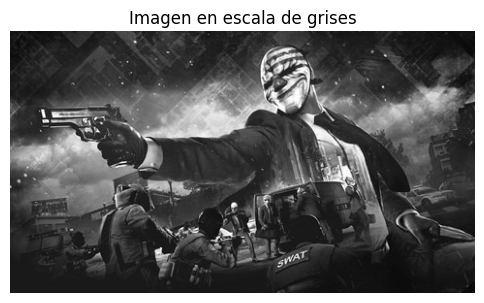

In [5]:
# Ruta de tu imagen (puede ser JPG, PNG, etc.)
img_path = 'imagen_gris.jpg'

# Carga directa en modo gris
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Verificamos dimensiones
print('Dimensiones:', gray.shape)

# Mostramos la imagen gris
plt.figure(figsize=(6,6))
plt.title('Imagen en escala de grises')
plt.axis('off')
plt.imshow(gray, cmap='gray')


Umbral aplicado: 127.0


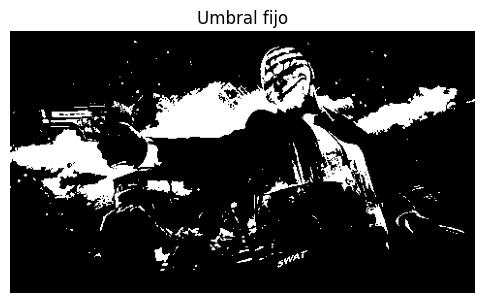

In [6]:
# Parámetros: valor de umbral, valor máximo, tipo de threshold
thresh_value = 127       # umbral entre 0 y 255
max_value    = 255       # valor para píxeles por encima del umbral

# cv2.threshold devuelve: ret (umbral usado) y la imagen binaria
ret, binary_fixed = cv2.threshold(gray, thresh_value, max_value, cv2.THRESH_BINARY)

print(f'Umbral aplicado: {ret}')

# Mostramos resultado
plt.figure(figsize=(6,6))
plt.title('Umbral fijo')
plt.axis('off')
plt.imshow(binary_fixed, cmap='gray')


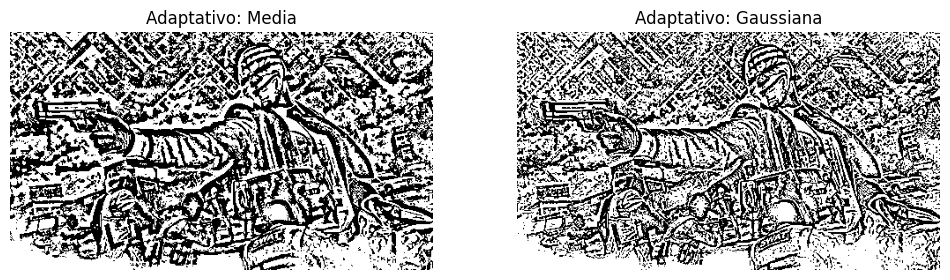

In [7]:
# Parámetros: valor máximo, método adaptativo, tipo de threshold, tamaño de bloque, constante C
block_size = 11   # dimensión del vecindario (debe ser impar)
C_value    = 2    # constante a restar de la media o weighted sum

# Umbral adaptativo por media
binary_adapt_mean = cv2.adaptiveThreshold(
    gray, max_value,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY,
    block_size,
    C_value
)

# Umbral adaptativo con Gaussiana ponderada
binary_adapt_gauss = cv2.adaptiveThreshold(
    gray, max_value,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    block_size,
    C_value
)

# Mostramos resultados lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].set_title('Adaptativo: Media')
axes[1].set_title('Adaptativo: Gaussiana')
for ax, img in zip(axes, [binary_adapt_mean, binary_adapt_gauss]):
    ax.axis('off')
    ax.imshow(img, cmap='gray')


Número de contornos detectados: 259


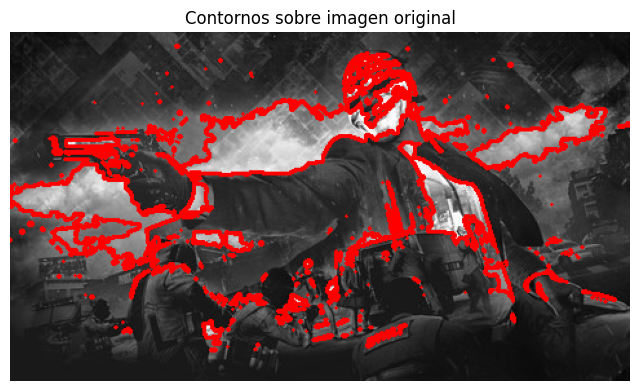

In [8]:
# --- 1. Prepara imagen de entrada para dibujo ---
# Si tu imagen original está en escala de grises, conviértela a BGR
# para poder dibujar contornos de color.
img_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

# Escoge la imagen binaria sobre la que detectarás contornos:
#    binary_fixed, binary_adapt_mean o binary_adapt_gauss
binary = binary_fixed  # por ejemplo

# --- 2. Detectar contornos ---
# cv2.findContours devuelve: contornos, jerarquía
# En OpenCV 4.x: contours, hierarchy = cv2.findContours(...)
contours, hierarchy = cv2.findContours(
    binary,                     # imagen binaria de entrada
    cv2.RETR_EXTERNAL,          # modo de recuperación de contornos
    cv2.CHAIN_APPROX_SIMPLE     # método de aproximación de contornos
)

print(f"Número de contornos detectados: {len(contours)}")

# --- 3. Dibujar contornos ---
# Parámetros: 
#   img: imagen sobre la que dibujar
#   contours: lista de contornos
#   contourIdx: -1 para dibujar todos
#   color: BGR (aquí rojo: (0,0,255))
#   thickness: grosor de línea
contoured_img = img_bgr.copy()
cv2.drawContours(
    contoured_img,
    contours,
    -1,
    (0, 0, 255),
    2
)

# --- 4. Mostrar resultado ---
plt.figure(figsize=(8,8))
plt.title('Contornos sobre imagen original')
plt.axis('off')
# Convertimos BGR a RGB para matplotlib
plt.imshow(cv2.cvtColor(contoured_img, cv2.COLOR_BGR2RGB))


Número de formas detectadas: 259
Área promedio: 66.05 píxeles²
Perímetro promedio: 23.66 píxeles


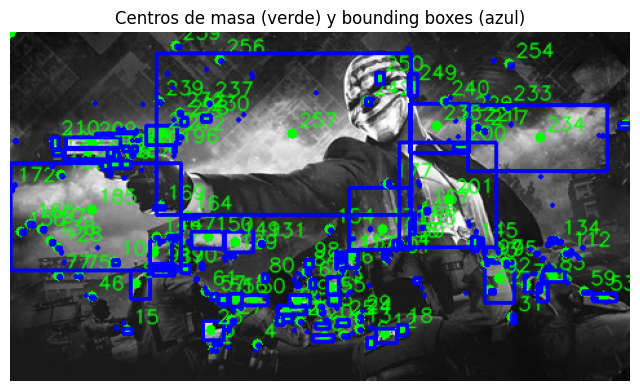

In [9]:
# --- Supuestos previos --- 
# contours: lista de contornos ya obtenida con cv2.findContours
# img_bgr: copia en BGR de la imagen original (para dibujar)
# contoured_img: copia sobre la que ya has dibujado contornos (opcional)
annotated = img_bgr.copy()

# Listas para métricas
areas = []
perimetros = []

for i, cnt in enumerate(contours, 1):
    # --- 1. Centro de masa ---
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        # evita división por cero
        cx, cy = 0, 0

    # dibuja un círculo pequeño en el centro
    cv2.circle(annotated, (cx, cy), 4, (0, 255, 0), -1)

    # --- 2. Bounding box ---
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(annotated, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # --- 3. Métricas de área y perímetro ---
    area = cv2.contourArea(cnt)
    perim = cv2.arcLength(cnt, True)
    areas.append(area)
    perimetros.append(perim)

    # opcional: etiqueta cada forma con su índice
    cv2.putText(
        annotated,
        str(i),
        (cx + 5, cy - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1,
        cv2.LINE_AA
    )

# --- 4. Cálculo de métricas globales ---
num_formas = len(contours)
area_prom = np.mean(areas) if areas else 0
perim_prom = np.mean(perimetros) if perimetros else 0

print(f"Número de formas detectadas: {num_formas}")
print(f"Área promedio: {area_prom:.2f} píxeles²")
print(f"Perímetro promedio: {perim_prom:.2f} píxeles")

# --- 5. Mostrar imagen anotada ---
plt.figure(figsize=(8,8))
plt.title('Centros de masa (verde) y bounding boxes (azul)')
plt.axis('off')
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
